# Mercado Livre API - Overview da API a partir de uma query
Esse notebook apresenta diferentes métricas que se pode obter ao realizar uma query à API do Mercado Libre. 

(No momento, experimentando com diferentes visualizações. Ao finalizar uma versão, a descrição dos passos será completada de acordo).

## Como usar

1. No menu superior: `Cell > Run All`
2. Digitar busca desejada no campo de texto e pressionar *Enter*
3. Aguardar alguns instantes até execução ser completada ("(Busy)" irá desaparecer do título da aba no browser)
4. Rolar para baixo e analisar os gráficos e tabelas

Para uma nova consulta, recomeçar do item 1. 

Obs.: caso a execução apresentar erros, clicar em `Kernel > Restart & Run All` no menu superior.

## Table of contents
- Resumo em lista dos itens com maior faturamento
- Faturamento por itens
- Visualização de quantidades vendidas, preço e estoque
- Análise por local do anúncio (cidade e estado)
- Análise por vendedores (faturamento relativo ao total)
- Histograma de itens adicionados no tempo (recenticidade das ofertas)
- Resumo em lista dos itens mais recentes
- Evolução das visitas aos itens com maior faturamento
- Evolução das visitas aos itens mais vendidos
- Evolução das visitas aos itens mais recentes

## Outputs
Ao final de cada execução, as tabelas de dados são salvas em um arquivo Excel com nome da *query* e data e hora de execução.


## Configurações
Pode-se ajustar o comportamento da análise alterando os valores dos *parâmetros de entrada*.

## Imports e configurações gerais

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

import requests
import pandas as pd

from pandas import Series, DataFrame

from IPython.core.display import Image, display

# Charts styling
#plt.style.use('fivethirtyeight')
#plt.style.use('bmh')
plt.style.use('ggplot')
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8 # increases figure size
matplotlib.rcParams.update({'font.size': 14}) # increases chart font size
rcParams['font.family'] = 'Arial Narrow'

In [2]:
# style to enhance df viz, from https://github.com/brandon-rhodes/pycon-pandas-tutorial
from IPython.core.display import HTML
css = open('style-table.css').read() #+ open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

## Parâmetros de entrada

In [3]:
# Sets input parameters 
DAYS_AGO = 365 # days to look back in visits history
ITEMS_TO_QUERY = 200 # number of itens requested per query (max. permitted by ML is 200)
TOTAL_ITEMS_TO_QUERY = 500 # max. number of results to be downloaded ("None" to make it limitless)
ITEMS_TO_PLOT = 10 # list of "ITEMS_TO_PLOT" top sold items; e.g. if 10, visits from top 10 sold itens will be plotted

## Busca de itens a partir de uma query definida pelo usuário

- Get dos resultados da busca
- Ordenamento dos itens por mais vendidos e remoção de itens duplicados
- Corte de itens pelo limite *ITEMS_TO_PLOT*

In [4]:
### REQUEST: gets items according to search for 'query' 

#query = "kit painel solar"
query = input('Qual a busca desejada? ')

offset = 0
received_itens = 0
results = []

payload = {'q': str(query), 'limit': str(1), 'offset': str(offset)}

url = 'https://api.mercadolibre.com/sites/MLB/search'#?q=' + query +'&limit=' + str(ITEMS_TO_QUERY)
print('Buscando por "' + query + '"')
data = requests.get(url, params=payload).json()

limit_itens = 0
total_itens = data['paging']['total']

print(str(total_itens) + ' resultados encontrados no ML.')

results = data['results'] # saves content from json in variable
df = DataFrame(results) # converts to a pandas df

# simple check for value sanity
if (TOTAL_ITEMS_TO_QUERY == None) or (TOTAL_ITEMS_TO_QUERY > total_itens):
    limit_itens = total_itens
else:
    limit_itens = TOTAL_ITEMS_TO_QUERY
    
print(str(limit_itens) + ' itens sendo transferidos. Aguarde...')


# makes requests querying 200 itens each time until gets all results
while len(df) < limit_itens:
    #print(offset)
    payload['offset'] = str(offset) # updates offset
    payload['limit']  = str(ITEMS_TO_QUERY)
    data = requests.get(url, params=payload).json()
    results = data['results'] # saves content from json in variable
    df.reset_index(drop=True)
    df = pd.concat([df, DataFrame(results)], axis=0) # concatenates new results to df
    offset = limit_itens - len(df) # updates offset
    progress = int((len(df)/limit_itens)*100)
    progress = 100 if progress > 100 else progress
    print(str(progress) + '%')

#print(str(len(df)) + ' itens encontrados.')

Qual a busca desejada? raspberry
Buscando por "raspberry"
1134 resultados encontrados no ML.
500 itens sendo transferidos. Aguarde...
40%
80%
100%


In [5]:
# selects a subset of columns, sorts by sold_quantity and fixes index

df = df[['id', 'title', 'price', 'sold_quantity', 'available_quantity', 'permalink', 'thumbnail', 'seller_address', 'seller', 'stop_time']]
df = df.sort_values('sold_quantity', ascending=False) # sorts df by most important column (to be defined, e.g. sold_quantity)
ids = df.id.values[0:ITEMS_TO_PLOT] # gets top sold items ML ids in a list
df = df.set_index('id') # sets index to id

df.head()

,title,price,sold_quantity,available_quantity,permalink,thumbnail,seller_address,seller,stop_time
id,,,,,,,,,
MLB707210043,Raspberry Pi 3 Quad 1.2ghz 1gb - Wifi Bluetoot...,249.90,1195,998,http://produto.mercadolivre.com.br/MLB-7072100...,http://mlb-s2-p.mlstatic.com/892721-MLB2084737...,"{'id': 68580076, 'latitude': -23.5580911, 'com...","{'id': 94906548, 'tags': [], 'power_seller_sta...",2036-08-31T16:27:46.000Z
MLB707210043,Raspberry Pi 3 Quad 1.2ghz 1gb - Wifi Bluetoot...,249.90,1195,998,http://produto.mercadolivre.com.br/MLB-7072100...,http://mlb-s2-p.mlstatic.com/892721-MLB2084737...,"{'id': 68580076, 'latitude': -23.5580911, 'com...","{'id': 94906548, 'tags': [], 'power_seller_sta...",2036-08-31T16:27:46.000Z
MLB758535016,Fonte Micro Usb 5v 3a Para O Raspberry Pi 1 - ...,24.99,1081,4894,http://produto.mercadolivre.com.br/MLB-7585350...,http://mlb-s1-p.mlstatic.com/357021-MLB2068874...,"{'id': 68580076, 'latitude': -23.5580911, 'com...","{'id': 94906548, 'tags': [], 'power_seller_sta...",2036-04-15T04:57:37.000Z
MLB759093632,"Raspberry Pi 3 Pi3 Quadcore 1.2ghz, 10x+rapido...",214.90,1071,58,http://produto.mercadolivre.com.br/MLB-7590936...,http://mlb-s2-p.mlstatic.com/582605-MLB2503786...,"{'id': 146282678, 'latitude': -30.0575594, 'co...","{'id': 128303656, 'tags': [], 'power_seller_st...",2036-10-06T19:39:43.000Z
MLB759093632,"Raspberry Pi 3 Pi3 Quadcore 1.2ghz, 10x+rapido...",214.90,1071,58,http://produto.mercadolivre.com.br/MLB-7590936...,http://mlb-s2-p.mlstatic.com/582605-MLB2503786...,"{'id': 146282678, 'latitude': -30.0575594, 'co...","{'id': 128303656, 'tags': [], 'power_seller_st...",2036-10-06T19:39:43.000Z


In [6]:
# sorts items by sold quantity and deletes duplicates with less sales (assuming they'd be 0)
df = df.sort_values(by='sold_quantity', ascending=False)
df = df.drop_duplicates(subset=['title'], keep='first')

# calculates total sold quantity
total_sold_quantity = df['sold_quantity'].sum()

# adds revenue column by an operation with sold_quantity and price
df['revenue'] = df['sold_quantity'] * df['price']
total_revenue = df['revenue'].sum()

# fixes 'stop_time' to proper date format
df['stop_time'] = pd.to_datetime(df['stop_time'])

# calculates start time and days ago
start_times = []
days_ago = []

today = dt.datetime.today()

# iterates over df to calculate 'start_time' subtracting 20 years from the 'stop_time' (value of 20 is default for ML's data)
for index, row in df.iterrows():
    stop_time = df.loc[index, 'stop_time']
    #df['start_time'][index] = date.replace(year = date.year - 20)
    start = stop_time
    start = start.replace(year = start.year - 20)
    ago = (today - start).days

    days_ago.append(ago)
    start_times.append(start)
    #print(str(start) + ' ' + str(stop_time))

df['start_time'] = start_times
df['days_ago'] = days_ago

#df
df.head()

,title,price,sold_quantity,available_quantity,permalink,thumbnail,seller_address,seller,stop_time,revenue,start_time,days_ago
id,,,,,,,,,,,,
MLB707210043,Raspberry Pi 3 Quad 1.2ghz 1gb - Wifi Bluetoot...,249.90,1195,998,http://produto.mercadolivre.com.br/MLB-7072100...,http://mlb-s2-p.mlstatic.com/892721-MLB2084737...,"{'id': 68580076, 'latitude': -23.5580911, 'com...","{'id': 94906548, 'tags': [], 'power_seller_sta...",2036-08-31 16:27:46,298630.50,2016-08-31 16:27:46,73
MLB758535016,Fonte Micro Usb 5v 3a Para O Raspberry Pi 1 - ...,24.99,1081,4894,http://produto.mercadolivre.com.br/MLB-7585350...,http://mlb-s1-p.mlstatic.com/357021-MLB2068874...,"{'id': 68580076, 'latitude': -23.5580911, 'com...","{'id': 94906548, 'tags': [], 'power_seller_sta...",2036-04-15 04:57:37,27014.19,2016-04-15 04:57:37,211
MLB759093632,"Raspberry Pi 3 Pi3 Quadcore 1.2ghz, 10x+rapido...",214.90,1071,58,http://produto.mercadolivre.com.br/MLB-7590936...,http://mlb-s2-p.mlstatic.com/582605-MLB2503786...,"{'id': 146282678, 'latitude': -30.0575594, 'co...","{'id': 128303656, 'tags': [], 'power_seller_st...",2036-10-06 19:39:43,230157.90,2016-10-06 19:39:43,37
MLB707758886,Raspberry Pi 3 Pi3 Quadcore 1.2ghz 10x + Rapid...,259.00,718,38,http://produto.mercadolivre.com.br/MLB-7077588...,http://mlb-s1-p.mlstatic.com/994705-MLB2507150...,"{'id': 68853228, 'latitude': -23.1867067, 'com...","{'id': 14370948, 'tags': [], 'power_seller_sta...",2035-09-20 12:46:38,185962.00,2015-09-20 12:46:38,419
MLB756523864,Raspberry Pi 3 Quadcore 1.2ghz (10x Rapido) 1g...,229.90,674,1999,http://produto.mercadolivre.com.br/MLB-7565238...,http://mlb-s2-p.mlstatic.com/154505-MLB2502480...,"{'id': 68580076, 'latitude': -23.5580911, 'com...","{'id': 94906548, 'tags': [], 'power_seller_sta...",2036-04-07 04:23:39,154952.60,2016-04-07 04:23:39,219


In [7]:
df.describe()

,price,sold_quantity,available_quantity,revenue,days_ago
count,468.000000,468.000000,468.000000,468.000000,468.000000
mean,169.146218,43.239316,549.931624,5612.437030,197.151709
std,277.410886,118.939615,4853.283550,24156.116109,128.326806
min,1.600000,0.000000,1.000000,0.000000,6.000000
25%,22.500000,4.000000,4.000000,256.935000,93.750000
50%,59.990000,10.000000,12.000000,764.150000,181.000000
75%,261.975000,32.000000,70.500000,2365.582500,288.000000
max,4100.000000,1195.000000,99994.000000,298630.500000,533.000000


## Resultado da busca e limpeza dos dados
Ordenamento por itens de maior faturamento.

Os 10 itens com maior faturamento: 



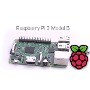

MLB707210043 - Raspberry Pi 3 Quad 1.2ghz 1gb - Wifi Bluetooth !! Excelente
http://produto.mercadolivre.com.br/MLB-707210043-raspberry-pi-3-quad-12ghz-1gb-wifi-bluetooth-excelente-_JM
1195 unidades vendidas.
Faturamento de R$ 298630.5.
Adicionado há 73 dias.



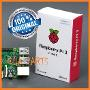

MLB759093632 - Raspberry Pi 3 Pi3 Quadcore 1.2ghz, 10x+rapido, 1gb Na Caixa
http://produto.mercadolivre.com.br/MLB-759093632-raspberry-pi-3-pi3-quadcore-12ghz-10xrapido-1gb-na-caixa-_JM
1071 unidades vendidas.
Faturamento de R$ 230157.9.
Adicionado há 37 dias.



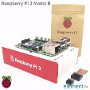

MLB707758886 - Raspberry Pi 3 Pi3 Quadcore 1.2ghz 10x + Rapido 1gb Na Caixa
http://produto.mercadolivre.com.br/MLB-707758886-raspberry-pi-3-pi3-quadcore-12ghz-10x-rapido-1gb-na-caixa-_JM
718 unidades vendidas.
Faturamento de R$ 185962.0.
Adicionado há 419 dias.



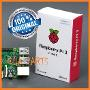

MLB700422024 - Raspberry Quadcore Pi3 Pi 3 Model B 1.2ghz 1gbram 10x+rapido
http://produto.mercadolivre.com.br/MLB-700422024-raspberry-quadcore-pi3-pi-3-model-b-12ghz-1gbram-10xrapido-_JM
653 unidades vendidas.
Faturamento de R$ 169714.7.
Adicionado há 72 dias.



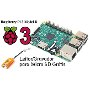

MLB756523864 - Raspberry Pi 3 Quadcore 1.2ghz (10x Rapido) 1gb !! Excelente
http://produto.mercadolivre.com.br/MLB-756523864-raspberry-pi-3-quadcore-12ghz-10x-rapido-1gb-excelente-_JM
674 unidades vendidas.
Faturamento de R$ 154952.6.
Adicionado há 219 dias.



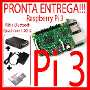

MLB750267265 - Kit Raspberry Pi 3 (pi3) + Case + Fonte + Cartão 32gb C. 10
http://produto.mercadolivre.com.br/MLB-750267265-kit-raspberry-pi-3-pi3-case-fonte-carto-32gb-c-10-_JM
319 unidades vendidas.
Faturamento de R$ 111331.0.
Adicionado há 244 dias.



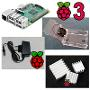

MLB763125127 - Raspberry Pi 3 + Case C/ Cooler + Fonte 5v + Dissipadores
http://produto.mercadolivre.com.br/MLB-763125127-raspberry-pi-3-case-c-cooler-fonte-5v-dissipadores-_JM
347 unidades vendidas.
Faturamento de R$ 111005.3.
Adicionado há 192 dias.



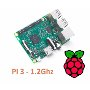

MLB748827075 - Novissimo Raspberry Pi 3 (pi3) Quadcore 1.2ghz 1gb Wifi B.t.
http://produto.mercadolivre.com.br/MLB-748827075-novissimo-raspberry-pi-3-pi3-quadcore-12ghz-1gb-wifi-bt-_JM
451 unidades vendidas.
Faturamento de R$ 99215.49.
Adicionado há 250 dias.



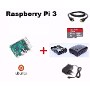

MLB748830867 - Kit Novo Raspberry Pi 3 Pi3 Completo+fonte+sd16+case+sistema
http://produto.mercadolivre.com.br/MLB-748830867-kit-novo-raspberry-pi-3-pi3-completofontesd16casesistema-_JM
167 unidades vendidas.
Faturamento de R$ 66130.33.
Adicionado há 250 dias.



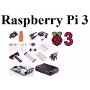

MLB702011029 - Raspberry Pi 3 - Ultimate Kit + De 35 Itens - Lançamento
http://produto.mercadolivre.com.br/MLB-702011029-raspberry-pi-3-ultimate-kit-de-35-itens-lancamento-_JM
109 unidades vendidas.
Faturamento de R$ 52318.91.
Adicionado há 434 dias.



In [8]:
# prints URLs from itens sorting by revenue

df = df.sort_values('revenue', ascending=False)

print('Os ' + str(ITEMS_TO_PLOT) + ' itens com maior faturamento:', '\n')
for index, row in df.head(ITEMS_TO_PLOT).iterrows():
    display(Image(df.loc[index, 'thumbnail']))
    print(index + ' - ' + df.loc[index, 'title']) # uses loc taking advantage of indexing by id made previously
    print(df.loc[index, 'permalink'])
    print(str(df.loc[index, 'sold_quantity']) + ' unidades vendidas.')
    print('Faturamento de R$ ' + str(df.loc[index, 'revenue']) + '.')
    print('Adicionado há ' + str(df.loc[index, 'days_ago']) + ' dias.')
    print()

## Faturamento por item

O faturamento total ("raspberry") = R$ 2626620.53


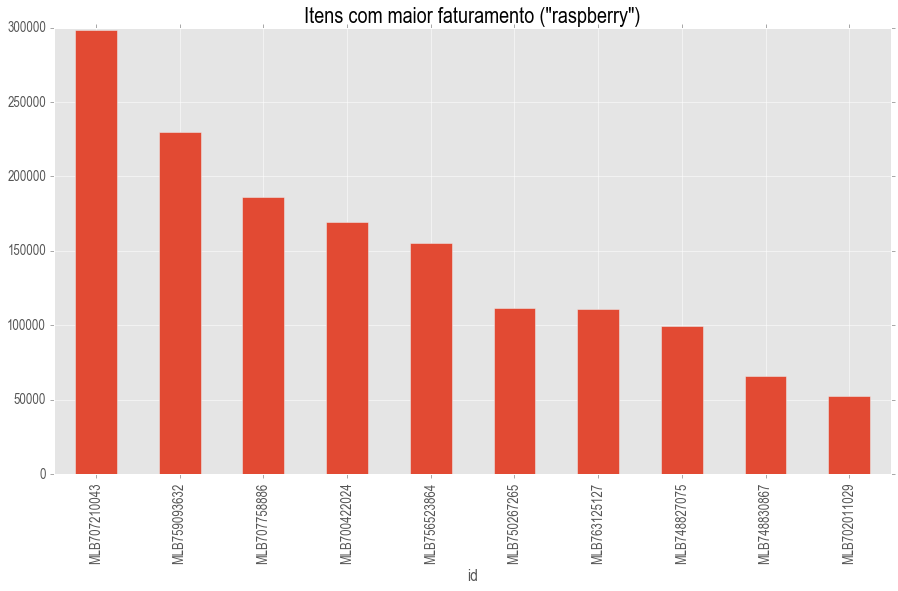

In [9]:
print('O faturamento total ("' + query + '") = R$ ' + str(total_revenue))
df['revenue'].sort_values(ascending=False).head(ITEMS_TO_PLOT).plot(kind='bar')
plt.title('Itens com maior faturamento ("' + query + '")', fontsize=22)

## Quantidade vendida e preços

Total de unidades vendidas ("raspberry") = 20236


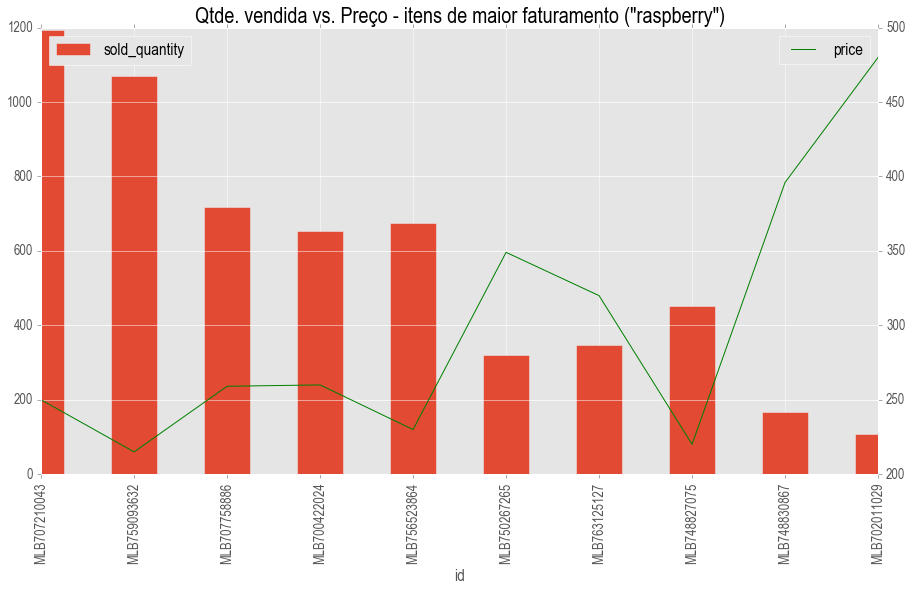

In [10]:
# sold quantity vs. unit price

print('Total de unidades vendidas ("' + query + '") = ' + str(total_sold_quantity))

# procedure to handle secondary Y axis
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()

y0 = df.head(ITEMS_TO_PLOT).sold_quantity.plot(kind='bar', ax=ax0)#, label='Itens vendidos')
y1 = df.head(ITEMS_TO_PLOT).price.plot(secondary_y=True, style='g', ax=ax1)#, label='Preço unitário')
y0.legend(loc=2) # bar legend to the left
y1.legend(loc=0) # line legend to the right

plt.title('Qtde. vendida vs. Preço - itens de maior faturamento ("' + query + '")', fontsize=22)
plt.show()
plt.close()

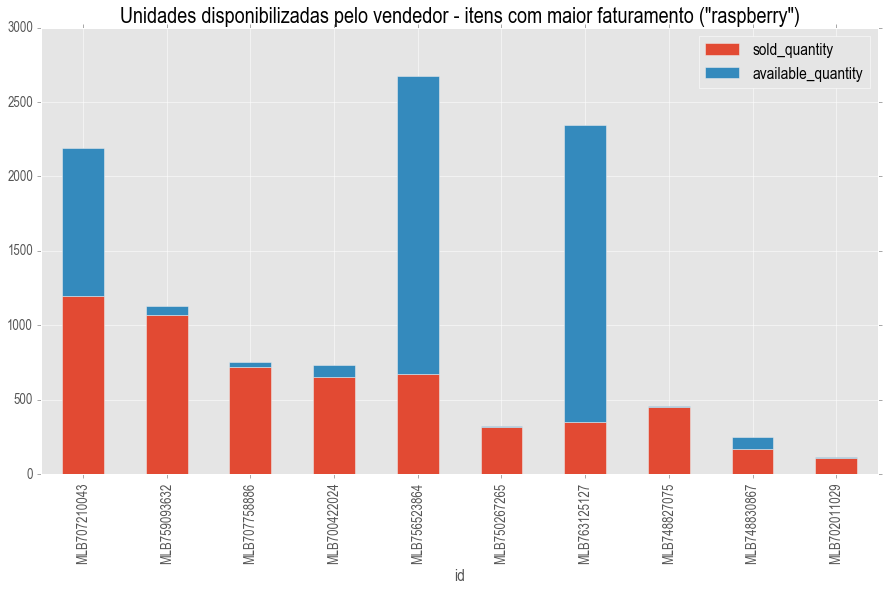

In [11]:
# total amount of each item (sold + stock)

df[['sold_quantity', 'available_quantity']].head(ITEMS_TO_PLOT).plot(kind='bar', stacked=True)
plt.title('Unidades disponibilizadas pelo vendedor - itens com maior faturamento ("' + query + '")', fontsize=22)

## Análise por cidade e estado (qtde. de anúncios e faturamento)

In [12]:
# location and stuff...

df2 = df # creates copy to play with

# extracting info from json/dict objects in cells

cities = [] # empty list to hold city names
states = [] # empty list to hold state names
sellers =[] # empty list to hold sellers ids

for index, row in df2.iterrows():
    cities.append(row['seller_address']['city']['name'])    
    states.append(row['seller_address']['state']['name'])    
    sellers.append(row['seller']['id'])    

df2['city'] = cities
df2['state'] = states
df2['seller_id'] = sellers
df2.head()

,title,price,sold_quantity,available_quantity,permalink,thumbnail,seller_address,seller,stop_time,revenue,start_time,days_ago,city,state,seller_id
id,,,,,,,,,,,,,,,
MLB707210043,Raspberry Pi 3 Quad 1.2ghz 1gb - Wifi Bluetoot...,249.9,1195,998,http://produto.mercadolivre.com.br/MLB-7072100...,http://mlb-s2-p.mlstatic.com/892721-MLB2084737...,"{'id': 68580076, 'latitude': -23.5580911, 'com...","{'id': 94906548, 'tags': [], 'power_seller_sta...",2036-08-31 16:27:46,298630.5,2016-08-31 16:27:46,73,São Paulo,São Paulo,94906548
MLB759093632,"Raspberry Pi 3 Pi3 Quadcore 1.2ghz, 10x+rapido...",214.9,1071,58,http://produto.mercadolivre.com.br/MLB-7590936...,http://mlb-s2-p.mlstatic.com/582605-MLB2503786...,"{'id': 146282678, 'latitude': -30.0575594, 'co...","{'id': 128303656, 'tags': [], 'power_seller_st...",2036-10-06 19:39:43,230157.9,2016-10-06 19:39:43,37,Porto Alegre,Rio Grande do Sul,128303656
MLB707758886,Raspberry Pi 3 Pi3 Quadcore 1.2ghz 10x + Rapid...,259.0,718,38,http://produto.mercadolivre.com.br/MLB-7077588...,http://mlb-s1-p.mlstatic.com/994705-MLB2507150...,"{'id': 68853228, 'latitude': -23.1867067, 'com...","{'id': 14370948, 'tags': [], 'power_seller_sta...",2035-09-20 12:46:38,185962.0,2015-09-20 12:46:38,419,São José dos Campos,São Paulo,14370948
MLB700422024,Raspberry Quadcore Pi3 Pi 3 Model B 1.2ghz 1gb...,259.9,653,78,http://produto.mercadolivre.com.br/MLB-7004220...,http://mlb-s1-p.mlstatic.com/585505-MLB2503787...,"{'id': 146282678, 'latitude': -30.0575594, 'co...","{'id': 128303656, 'tags': [], 'power_seller_st...",2036-09-01 16:27:10,169714.7,2016-09-01 16:27:10,72,Porto Alegre,Rio Grande do Sul,128303656
MLB756523864,Raspberry Pi 3 Quadcore 1.2ghz (10x Rapido) 1g...,229.9,674,1999,http://produto.mercadolivre.com.br/MLB-7565238...,http://mlb-s2-p.mlstatic.com/154505-MLB2502480...,"{'id': 68580076, 'latitude': -23.5580911, 'com...","{'id': 94906548, 'tags': [], 'power_seller_sta...",2036-04-07 04:23:39,154952.6,2016-04-07 04:23:39,219,São Paulo,São Paulo,94906548


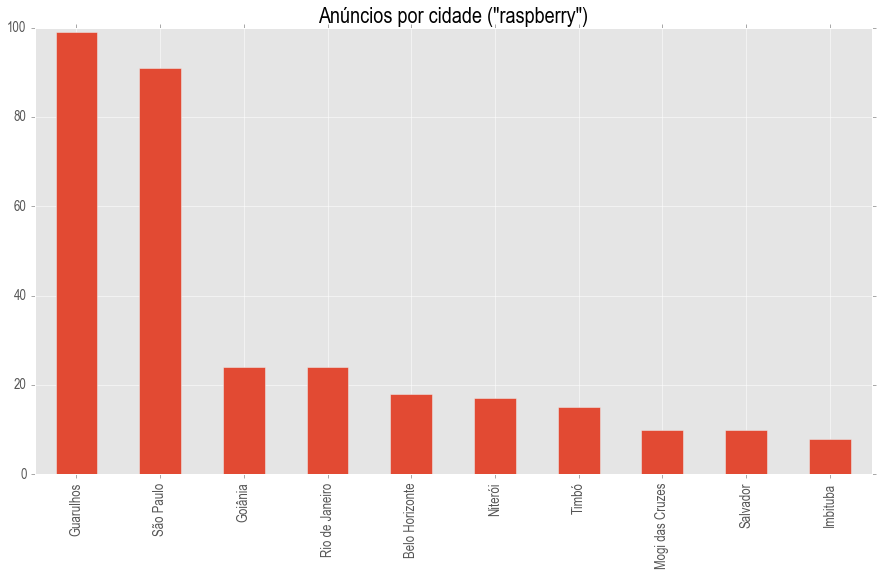

In [13]:
# plots itens by cities

df2.city.value_counts().head(10).plot(kind='bar')
plt.title('Anúncios por cidade ("' + query + '")', fontsize=22)

O faturamento total ("raspberry") = R$ 2626620.53


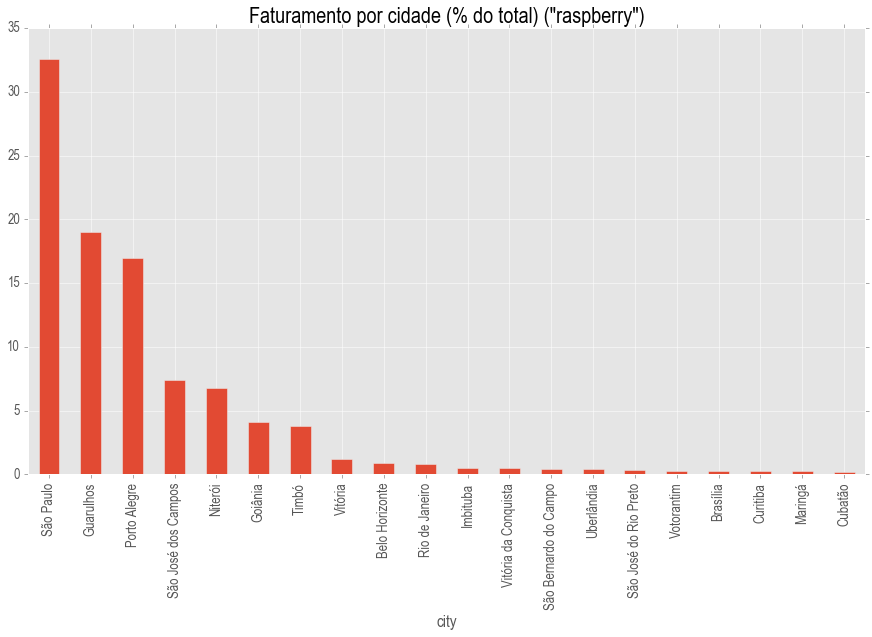

In [14]:
# revenue per city
print('O faturamento total ("' + query + '") = R$ ' + str(total_revenue))

revenue_share_by_city = (df2.groupby('city').sum().revenue / total_revenue) * 100 # aggregates data by city, sums by revenue and gets proportion from total
revenue_share_by_city.sort_values(ascending=False).head(20).plot(kind='bar')
plt.title('Faturamento por cidade (% do total) ("' + query + '")', fontsize=22)

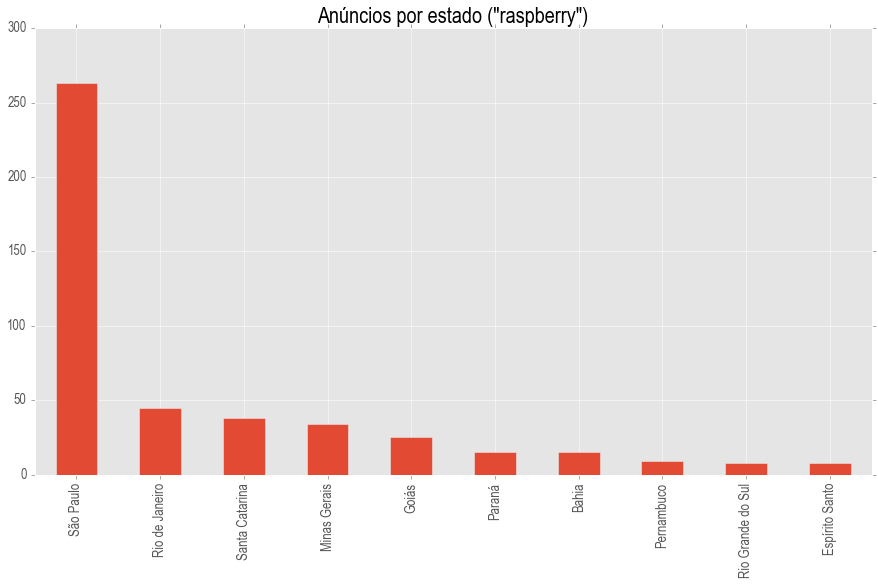

In [15]:
# plots itens by states
df2.state.value_counts().head(10).plot(kind='bar')
plt.title('Anúncios por estado ("' + query + '")', fontsize=22)

O faturamento total ("raspberry") = R$ 2626620.53


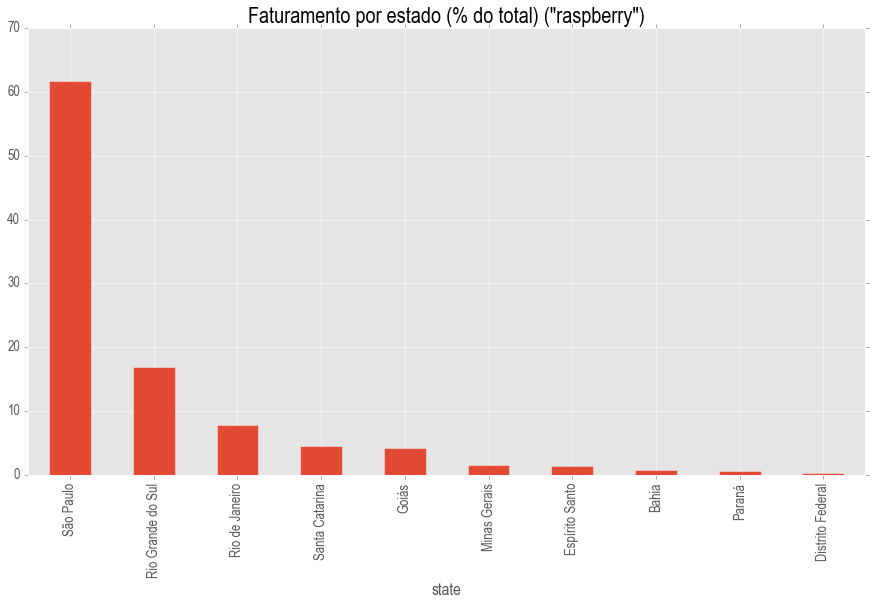

In [16]:
print('O faturamento total ("' + query + '") = R$ ' + str(total_revenue))

revenue_share_by_state = (df2.groupby('state').sum().revenue / total_revenue) * 100
revenue_share_by_state.sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Faturamento por estado (% do total) ("' + query + '")', fontsize=22)

## Análise por vendedores

In [17]:
sellers_df = df2.groupby('seller_id').sum() # aggregates by sellers id, summing up the columns
sellers_df.price = df2.groupby('seller_id').mean().price # substitutes sum of prices by mean price by seller
sellers_df = sellers_df.rename(columns={'price': 'average_price'})
sellers_df.sort_values('revenue', ascending=False).head()

,average_price,sold_quantity,available_quantity,revenue,days_ago
seller_id,,,,,
94906548,161.652727,4880,23002,680471.85,3830
128303656,1025.642857,1886,224,445111.90,479
33244359,205.247571,2681,4419,402593.54,15412
14370948,259.000000,755,88,195545.00,485
80428828,334.175294,551,102,178226.39,1398


O faturamento total ("raspberry") = R$ 2626620.53


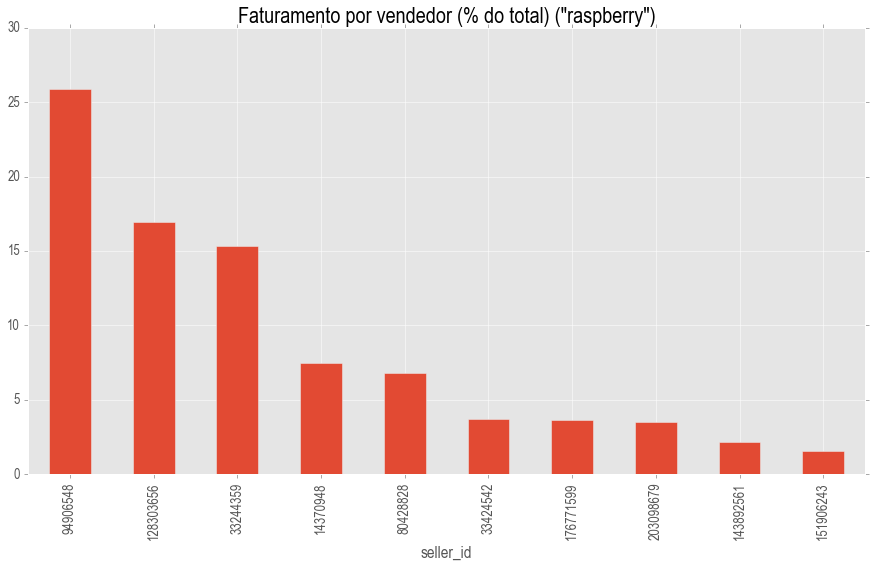

In [18]:
print('O faturamento total ("' + query + '") = R$ ' + str(total_revenue))

sellers_df = sellers_df.sort_values('revenue', ascending=False)
#sellers_df.revenue.sort_values(ascending=False).head(20).plot(kind='bar')

revenue_share_by_seller = (sellers_df['revenue'] / total_revenue) * 100
revenue_share_by_seller.head(10).plot(kind='bar')
plt.title('Faturamento por vendedor (% do total) ("' + query + '")', fontsize=22)
#sellers_df.head()

### Vendedor e itens como índices
Verificar como operar e se é útil de alguma forma...

In [19]:
# groups sellers and items, and then ...?
s = df2.reset_index()
s = s.groupby(['seller_id', 'id', 'permalink']).sum() # aggregates data by id and permalink to "save" them from being hidden

# sets id and permalink to be data in df
s = s.reset_index('id')
s = s.reset_index('permalink')

#reorder columns to make it readable
s = s[['id', 'sold_quantity', 'price', 'revenue', 'available_quantity', 'permalink']] 

s.head(10)

,id,sold_quantity,price,revenue,available_quantity,permalink
seller_id,,,,,,
1760611,MLB775817622,36,179.99,6479.64,11,http://produto.mercadolivre.com.br/MLB-7758176...
2220415,MLB791207537,4,19.90,79.60,31,http://produto.mercadolivre.com.br/MLB-7912075...
4308029,MLB726980390,3,269.00,807.00,1,http://produto.mercadolivre.com.br/MLB-7269803...
4308029,MLB740753227,3,39.00,117.00,6,http://produto.mercadolivre.com.br/MLB-7407532...
4308029,MLB790933232,6,299.00,1794.00,12,http://produto.mercadolivre.com.br/MLB-7909332...
4627643,MLB777462031,11,9.62,105.82,1,http://produto.mercadolivre.com.br/MLB-7774620...
5664031,MLB743455948,9,35.00,315.00,91,http://produto.mercadolivre.com.br/MLB-7434559...
5664031,MLB757791258,55,35.00,1925.00,45,http://produto.mercadolivre.com.br/MLB-7577912...
5664031,MLB762428955,32,54.99,1759.68,94,http://produto.mercadolivre.com.br/MLB-7624289...


## Análise da data de anúncio dos itens (recenticidade)

In [20]:
# plot by days_ago (by date as the following charts is nicer)
#_range = (0, 30)
#df.days_ago.hist(range=_range, bins=30)
#plt.title('Distribuição de itens adicionados nos últimos 30 dias (dias atrás) ("' + query + '")', fontsize=22)

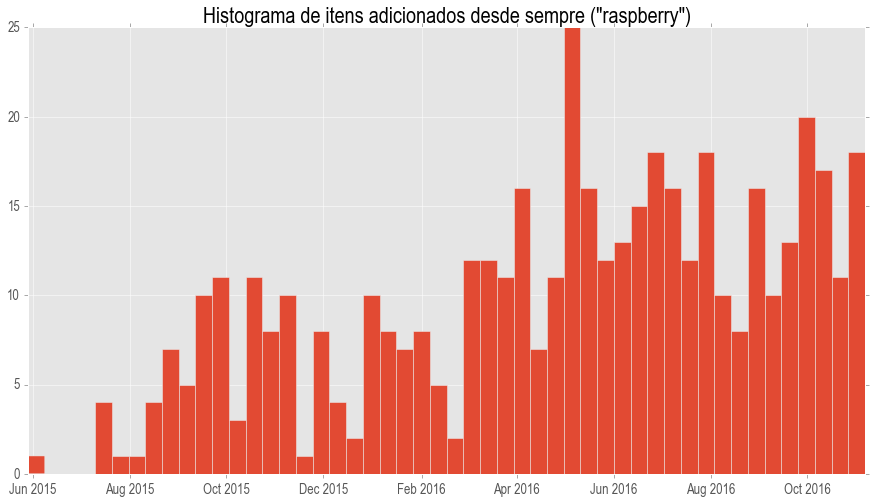

In [21]:
s = df

s.start_time.hist(bins=50)
plt.title('Histograma de itens adicionados desde sempre ("' + query + '")', fontsize=22)

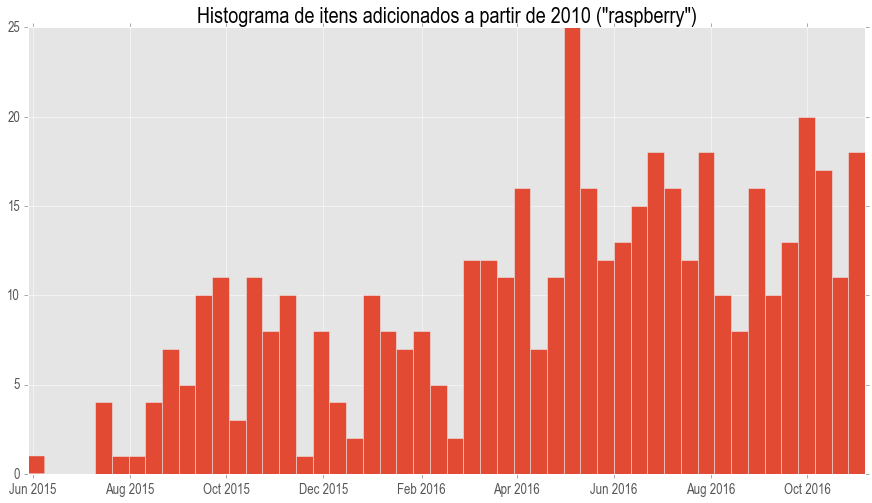

In [22]:
s = df[(df.start_time > '2010-01-01')] # filter dates later than 2010

s.start_time.hist(bins=50)
plt.title('Histograma de itens adicionados a partir de 2010 ("' + query + '")', fontsize=22)

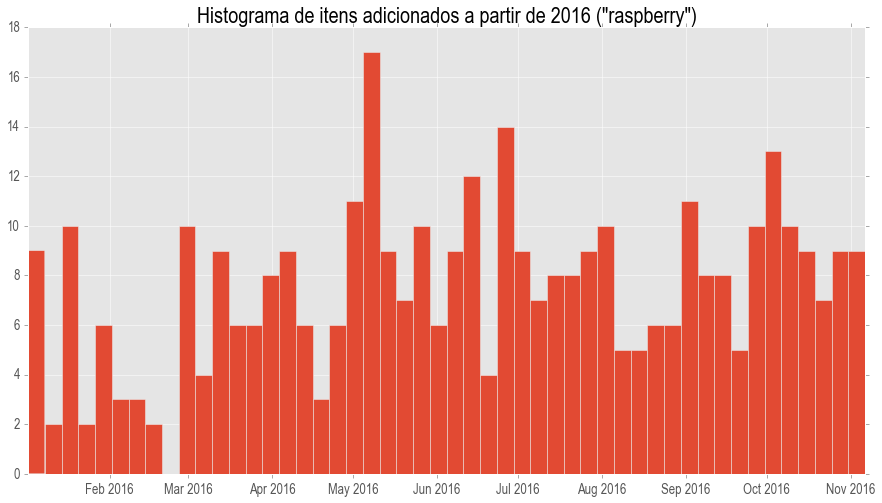

In [23]:
s = df[(df.start_time > '2016-01-01')] # filter dates later than 2016

s.start_time.hist(bins=50)
plt.title('Histograma de itens adicionados a partir de 2016 ("' + query + '")', fontsize=22)

Os 10 itens mais recentes: 



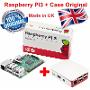

MLB811653517 - Raspberry Pi3 Model B Quadcore - Uk + Case Original Branca
http://produto.mercadolivre.com.br/MLB-811653517-raspberry-pi3-model-b-quadcore-uk-case-original-branca-_JM
Adicionado há 6 dias.
0 unidade(s) já vendida(s).



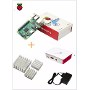

MLB811253380 - Kit Raspberry Pi3 (pi 3) +case(d)+dissipadores+fonte 5v 2.5a
http://produto.mercadolivre.com.br/MLB-811253380-kit-raspberry-pi3-pi-3-caseddissipadoresfonte-5v-25a-_JM
Adicionado há 7 dias.
1 unidade(s) já vendida(s).



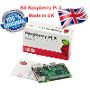

MLB810536337 - Raspberry Pi3 Model B Quadcore 1.2ghz 1gb Ram Uk - Oferta !
http://produto.mercadolivre.com.br/MLB-810536337-raspberry-pi3-model-b-quadcore-12ghz-1gb-ram-uk-oferta--_JM
Adicionado há 9 dias.
4 unidade(s) já vendida(s).



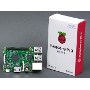

MLB810455120 - Raspberry Pi3 Pi 3 Model B Quadcore 1.2ghz Lançamento
http://produto.mercadolivre.com.br/MLB-810455120-raspberry-pi3-pi-3-model-b-quadcore-12ghz-lancamento-_JM
Adicionado há 10 dias.
1 unidade(s) já vendida(s).



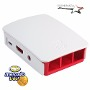

MLB804988260 - Case Raspberry Pi3 - Oficial - Envio Mais Rapido Do Brasil
http://produto.mercadolivre.com.br/MLB-804988260-case-raspberry-pi3-oficial-envio-mais-rapido-do-brasil-_JM
Adicionado há 10 dias.
4 unidade(s) já vendida(s).



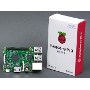

MLB810454836 - Raspberry Pi3 Pi 3 Model B Quadcore 1.2ghz Pronta Entrega
http://produto.mercadolivre.com.br/MLB-810454836-raspberry-pi3-pi-3-model-b-quadcore-12ghz-pronta-entrega-_JM
Adicionado há 10 dias.
6 unidade(s) já vendida(s).



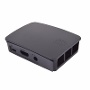

MLB810078580 - Case Raspberry Pi 3 Model B Original Pi 2 - Pi3 - Preta
http://produto.mercadolivre.com.br/MLB-810078580-case-raspberry-pi-3-model-b-original-pi-2-pi3-preta-_JM
Adicionado há 11 dias.
3 unidade(s) já vendida(s).



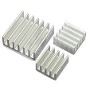

MLB732418960 - Dissipador Calor Com Fita Auto Colante Raspberry Pi
http://produto.mercadolivre.com.br/MLB-732418960-dissipador-calor-com-fita-auto-colante-raspberry-pi-_JM
Adicionado há 12 dias.
60 unidade(s) já vendida(s).



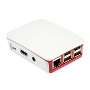

MLB809971545 - Case Raspberry Pi 3 Model B Original Pi 2 - Official - Pi3
http://produto.mercadolivre.com.br/MLB-809971545-case-raspberry-pi-3-model-b-original-pi-2-official-pi3-_JM
Adicionado há 12 dias.
1 unidade(s) já vendida(s).



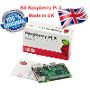

MLB684611059 - Raspberry Pi3 Pi 3 Model B Quadcore 1.2ghz - Reino Unido Uk
http://produto.mercadolivre.com.br/MLB-684611059-raspberry-pi3-pi-3-model-b-quadcore-12ghz-reino-unido-uk-_JM
Adicionado há 14 dias.
19 unidade(s) já vendida(s).



In [24]:
print('Os ' + str(ITEMS_TO_PLOT) + ' itens mais recentes:', '\n')

recent_itens_df = df.sort_values('days_ago', ascending=True)

for index, row in recent_itens_df.head(ITEMS_TO_PLOT).iterrows():
    display(Image(df.loc[index, 'thumbnail'])) 
    print(index + ' - ' + df.loc[index, 'title']) # uses loc taking advantage of indexing by id made previously
    print(df.loc[index, 'permalink'])
    print('Adicionado há ' + str(df.loc[index, 'days_ago']) + ' dias.')
    print(str(df.loc[index, 'sold_quantity']) + ' unidade(s) já vendida(s).')
    print()

    

---
## Request por visitas dos itens filtrados e ordenados

- Itens mais vendidos
- Itens mais recentes

### Função para gerar DataFrame de visitas

In [25]:
def get_visits_df(days, ids):
    
    ids_string = ','.join(ids) # makes comma-separated string from list to use in URL

    url = 'https://api.mercadolibre.com/items/visits/time_window?ids=' + ids_string +'&last=' + str(days) + '&unit=day'
    data = requests.get(url).json()

    visits_df = DataFrame(data[0]['results']) # initialize a df with the first item out of 10 (top ten in ids_string)
    visits_df = visits_df[['date', 'total']] # gets only main columns
    visits_df.columns = ['date', data[0]['item_id']] # renames 'total' to item's ID

    column_headers = [] # list to store item ids used as column headers
    column_headers.append(data[0]['item_id'])

    # iterates over data items to merge all 'total' columns into same df
    for item in data[1:]:
        results = item['results']
        df_temp = DataFrame(results)
        df_temp = df_temp[['date', 'total']]
        df_temp.columns = ['date', item['item_id']]
        column_headers.append(item['item_id'])
        visits_df = pd.merge(visits_df, df_temp, on='date')

    #print(column_headers)
    #visits_df.head()

    # fixes df, parsing 'date' properly and setting as index column
    visits_df['date'] = pd.to_datetime(visits_df['date'])
    visits_df = visits_df.set_index('date')

    #visits_df.head()
    return visits_df

### Visitas aos itens com maior faturamento

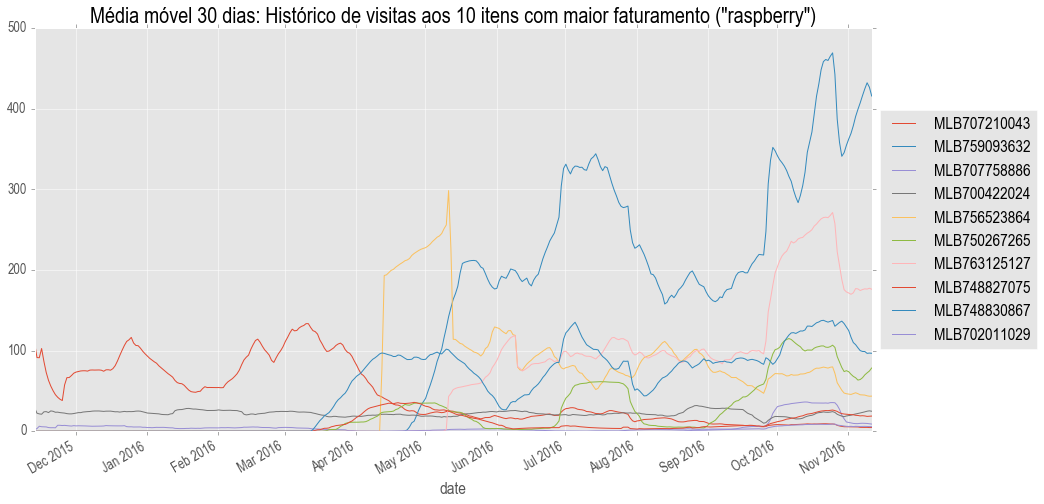

In [26]:
# defines ids from top revenue itens
top_revenue_ids = df.sort_values('revenue', ascending=False).index.values[0:ITEMS_TO_PLOT]

# get df by calling function with top sold ids
visits_df = get_visits_df(DAYS_AGO, top_revenue_ids)

# calculates and plots visits' rolling mean (smoother curves)
days_rolling = 30;
rolling_mean_df = visits_df.rolling(window=days_rolling, min_periods=1).mean() # window is the # of days evaluated in rolling mean
ax = rolling_mean_df.plot();
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # moves legend to the right outside
plt.title('Média móvel ' + str(days_rolling) + ' dias: Histórico de visitas aos ' + str(ITEMS_TO_PLOT) + ' itens com maior faturamento ("' + query + '")', fontsize=22)

most_revenue_visits_df = visits_df # saves to a uniquely named df to be exported later

### Visitas aos itens mais vendidos

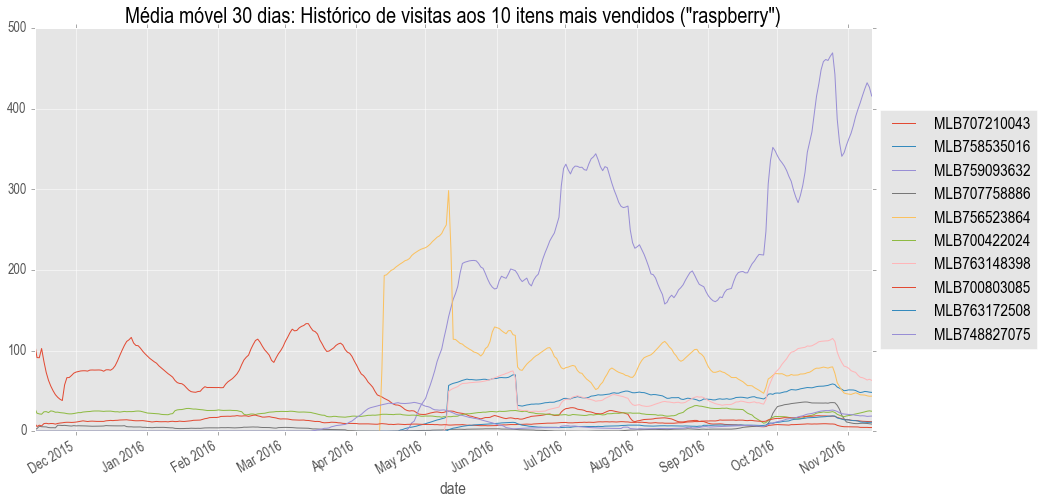

In [27]:
# defines ids from top sold itens
top_sold_ids = df.sort_values('sold_quantity', ascending=False).index.values[0:ITEMS_TO_PLOT]

# get df by calling function with top sold ids
visits_df = get_visits_df(DAYS_AGO, top_sold_ids)

# calculates and plots visits' rolling mean (smoother curves)
days_rolling = 30;
rolling_mean_df = visits_df.rolling(window=days_rolling, min_periods=1).mean() # window is the # of days evaluated in rolling mean
ax = rolling_mean_df.plot();
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # moves legend to the right outside
plt.title('Média móvel ' + str(days_rolling) + ' dias: Histórico de visitas aos ' + str(ITEMS_TO_PLOT) + ' itens mais vendidos ("' + query + '")', fontsize=22)

most_sold_visits_df = visits_df # saves to a uniquely named df to be exported later

### Visitas aos itens mais recentes

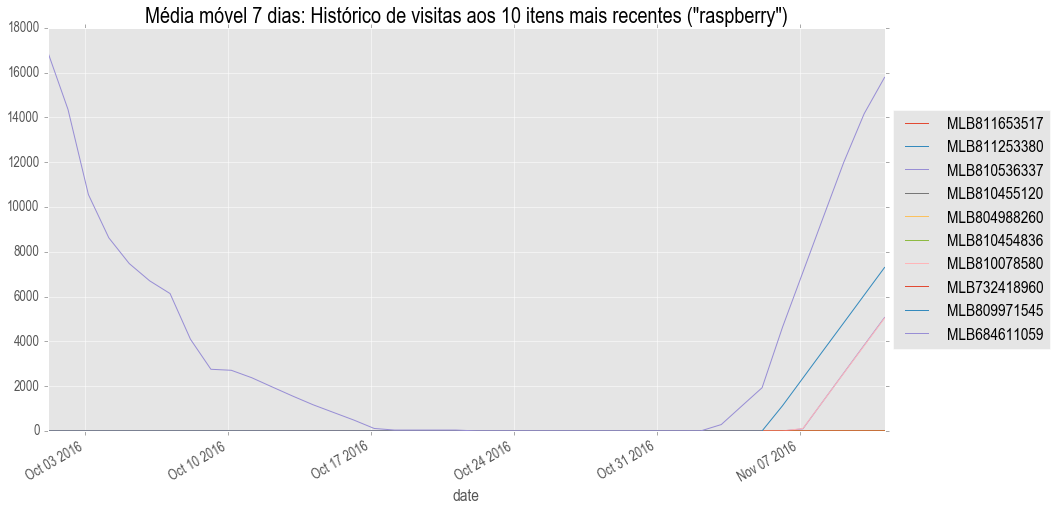

In [28]:
# gets ids from most recent itens
recent_ids = recent_itens_df.index.values[0:ITEMS_TO_PLOT] # gets most recent items ML ids in a list

# get df by calling function with most recent ids
visits_df = get_visits_df(DAYS_AGO, recent_ids)
visits_df = visits_df['2016-10-01':] # filters by some date (e.g. 1st of january, 2016)

# calculates and plots visits' rolling mean (smoother curves)
days_rolling = 7;
rolling_mean_df = visits_df.rolling(window=days_rolling, min_periods=1).mean() # window is the # of days evaluated in rolling mean
ax = rolling_mean_df.plot();
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # moves legend to the right outside
plt.title('Média móvel ' + str(days_rolling) + ' dias: Histórico de visitas aos ' + str(ITEMS_TO_PLOT) + ' itens mais recentes ("' + query + '")', fontsize=22)

most_recent_visits_df = visits_df # saves to a uniquely named df to be exported later

In [29]:
# normal plot
#plt.figure()
#visits_df.plot(legend=True);
#plt.title('Histórico de visitas aos 10 itens mais vendidos ("' + query + '")', fontsize=22)

# cumulative sum plot
#cumulative_visits_df = visits_df.cumsum() # calculates accumulated values to plot
#plt.figure();
#cumulative_visits_df.plot(legend=True);
#plt.title('Soma acumulada: Histórico de visitas aos 10 itens mais vendidos ("' + query + '")', fontsize=22)

## Exporta dados para Excel
Salva os principais DataFrames em diferentes abas de um arquivo .xlsx e salva na pasta raiz.

In [30]:
# saves main df to Excel format
today_str = today.strftime('%Y-%m-%d_%H%M') # makes string with today's date

writer = pd.ExcelWriter(today_str + '_' + query + '.xlsx')

df.to_excel(writer, 'main_data')
sellers_df.to_excel(writer, 'sellers')
most_revenue_visits_df.to_excel(writer, 'visits-revenue_sold')
most_sold_visits_df.to_excel(writer, 'visits-most_sold')
most_recent_visits_df.to_excel(writer, 'visits-most_recent')

writer.save()
writer.close()

## Todo:
**Features**
- Plot itens by seller location (map?)
- <s>Calculate revenue per seller (extract from seller dict in raw df)</s>
- <s>Understand data aggregated by SELLER, not only by separate items</s>
- Get location of the BUYERS, not only sellers
- Compare seller revenue with its ratings/feedbacks
- <s>Analyse itens by date and recently added itens</s>
- <s>Play around with 'added_days_ago' and 'sold_quantity' = how appealing the product is</s>
- Filter by minimum item price
---
**Code improvement**
- Fix query handling for 0 results
- Fix query handling for null query as input
- Fix documentation/description
- Make dates relative to today's (e.g. instead of '2016', get the year from datetime 'today')
---
**Usability**
- Add an index for jumping to parts (links for navigation)